## Setup

In [1]:
# cellranger import
#import modules, define some functions for loading, saving and processing a gene-barcode matrix
%matplotlib inline
import pkg_resources
import collections
import numpy as np
import pandas as pd
import scipy.sparse as sp_sparse
import tables
import matplotlib
import matplotlib.pyplot as plt
import h5py

np.random.seed(0)

GeneBCMatrix = collections.namedtuple('GeneBCMatrix', ['gene_ids', 'gene_names', 'barcodes', 'matrix'])

def get_matrix_from_h5(filename, genome):
    with tables.open_file(filename, 'r') as f:
        try:
            dsets = {}
            for node in f.walk_nodes('/' + genome, 'Array'):
                dsets[node.name] = node.read()
            matrix = sp_sparse.csc_matrix((dsets['data'], dsets['indices'], dsets['indptr']), shape=dsets['shape'])
            if 'id' in dsets.keys():
                return GeneBCMatrix(dsets['id'], dsets['name'], dsets['barcodes'], matrix)
            else:
                return GeneBCMatrix(dsets['genes'], dsets['gene_names'], dsets['barcodes'], matrix)
        except tables.NoSuchNodeError:
            raise Exception("Genome %s does not exist in this file." % genome)
        except KeyError:
            raise Exception("File is missing one or more required datasets.")

def save_matrix_to_h5(gbm, filename, genome):
    flt = tables.Filters(complevel=1)
    with tables.open_file(filename, 'w', filters=flt) as f:
        try:
            group = f.create_group(f.root, genome)
            f.create_carray(group, 'genes', obj=gbm.gene_ids)
            f.create_carray(group, 'gene_names', obj=gbm.gene_names)
            f.create_carray(group, 'barcodes', obj=gbm.barcodes)
            f.create_carray(group, 'data', obj=gbm.matrix.data)
            f.create_carray(group, 'indices', obj=gbm.matrix.indices)
            f.create_carray(group, 'indptr', obj=gbm.matrix.indptr)
            f.create_carray(group, 'shape', obj=gbm.matrix.shape)
        except:
            raise Exception("Failed to write H5 file.")
        
def subsample_matrix(gbm, barcode_indices):
    return GeneBCMatrix(gbm.gene_ids, gbm.gene_names, gbm.barcodes[barcode_indices], gbm.matrix[:, barcode_indices])

def get_expression(gbm, gene_name):
    gene_indices = np.where(gbm.gene_names == gene_name)[0]
    if len(gene_indices) == 0:
        raise Exception("%s was not found in list of gene names." % gene_name)
    return gbm.matrix[gene_indices[0], :].toarray().squeeze()

def save_count_matrix_to_h5(E, gene_list, filename):
    with h5py.File(filename, 'w') as hf:
        hf.create_dataset("indptr" ,  data= E.indptr)
        hf.create_dataset("indices",  data= E.indices)
        hf.create_dataset("data"   ,  data= E.data)
        hf.create_dataset("shape"  ,  data= E.shape)
        hf.create_dataset("genes"  ,  data= gene_list)

In [2]:
%pylab inline
from helper_functions import *
#from doublet_detector import *
from collections import defaultdict

Populating the interactive namespace from numpy and matplotlib


In [3]:
#plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'DejaVu Sans'
plt.rc('font', size=14)
plt.rcParams['pdf.fonttype'] = 42

In [4]:
!wget http://cf.10xgenomics.com/samples/cell-exp/2.1.0/pbmc8k/pbmc8k_raw_gene_bc_matrices_h5.h5

--2021-02-02 17:03:13--  http://cf.10xgenomics.com/samples/cell-exp/2.1.0/pbmc8k/pbmc8k_raw_gene_bc_matrices_h5.h5
Resolving cp-tinyproxy.default.svc.cluster.local (cp-tinyproxy.default.svc.cluster.local)... 10.105.184.90
Connecting to cp-tinyproxy.default.svc.cluster.local (cp-tinyproxy.default.svc.cluster.local)|10.105.184.90|:3128... connected.
Proxy request sent, awaiting response... 301 Moved Permanently
Location: https://cf.10xgenomics.com/samples/cell-exp/2.1.0/pbmc8k/pbmc8k_raw_gene_bc_matrices_h5.h5 [following]
--2021-02-02 17:03:13--  https://cf.10xgenomics.com/samples/cell-exp/2.1.0/pbmc8k/pbmc8k_raw_gene_bc_matrices_h5.h5
Connecting to cp-tinyproxy.default.svc.cluster.local (cp-tinyproxy.default.svc.cluster.local)|10.105.184.90|:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 32549555 (31M) [binary/octet-stream]
Saving to: 'pbmc8k_raw_gene_bc_matrices_h5.h5.2'

pbmc8k_raw_gene_bc_ 100%[===================>]  31.04M  50.4MB/s    in 0.6s    

2021-0

In [5]:
sample_list = ["Sample1"]

## Load data

In [6]:
# D stores all the data; one entry per library
D = {}

for j, s in enumerate(sample_list):
    filename = 'pbmc8k_raw_gene_bc_matrices_h5.h5'
    raw_matrix_h5 = filename
    print raw_matrix_h5
    if filename == 'raw_feature_bc_matrix.h5':
        genome = "matrix"
    else:
        genome = 'GRCh38'
    D[s] = {}
    D[s]['meta'] = {}
    gbm = get_matrix_from_h5(raw_matrix_h5, genome)
    D[s]['E'] = transpose(gbm.matrix)
    D[s]['meta']['gene_list']=gbm.gene_names
    D[s]['meta']['gene_id']=gbm.gene_ids
    print D[s]['E'].shape
    D[s]['cell_index']=gbm.barcodes
    print (len(D[s]['cell_index']))

pbmc8k_raw_gene_bc_matrices_h5.h5
(737280, 33694)
737280


In [7]:
gene_list = D[s]['meta']['gene_list']
gene_id = D[s]['meta']['gene_id']

## Filter cells by total counts and number of genes detected


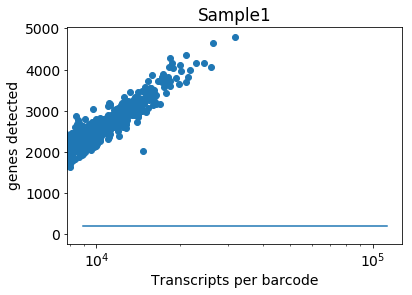

In [8]:
# plot total counts histograms - don't actually filter out any barcodes yet


# adjust total counts thresholds

for j,s in enumerate(sample_list):
    D[s]['total_counts'] = np.sum(D[s]['E'], axis=1).A[:,0]
    D[s]['genes_detected'] = np.sum(D[s]['E']>0, axis=1).A[:,0]
    D[s]['meta']['min_tot']= np.mean(D[s]['total_counts'])+np.std(D[s]['total_counts'])
    D[s]['meta']['min_genes_detected']=200;
    if 0:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.hist(D[s]['total_counts'], bins=np.logspace(0, 6, 50))
        ax.set_xscale('log')
        ax.set_xlabel('Transcripts per barcode')
        ax.set_ylabel('Number of barcodes')

        ax.plot([D[s]['meta']['min_tot'],D[s]['meta']['min_tot']],ax.get_ylim());
        title(s)

        fig2 = plt.figure()
        ax2 = fig2.add_subplot(111)
        ax2.set_xscale('log')
        ax2.set_xlabel('Genes per barcode ')
        ax2.set_ylabel('Number of barcodes')
        ax2.hist(D[s]['genes_detected'], bins=np.logspace(0, 6, 50))


    fig3 = plt.figure()
    ax3 = fig3.add_subplot(111)
    ax3.set_xscale('log')
    ax3.set_xlabel('Transcripts per barcode')
    ax3.set_ylabel('genes detected')

    ax3.scatter(D[s]['total_counts'],D[s]['genes_detected']);
    ax3.plot(ax3.get_xlim(),[D[s]['meta']['min_genes_detected'],D[s]['meta']['min_genes_detected']]);
    title(s)
    
    

In [9]:
D_orig=D
for j,s in enumerate(sample_list):
    ix = (D[s]['genes_detected'] > 200) & (D[s]['total_counts'] > 500)
    print D_orig[s]['E'].shape[0]
    if np.sum(ix) > 0:
        print s, np.sum(ix), '/', D[s]['E'].shape[0], np.median(D[s]['total_counts'][ix]), np.mean(D[s]['total_counts'][ix])


737280
Sample1 8786 / 737280 4011.0 4465.14534487


In [10]:
# Actually filter out low-count barcodes
for j,s in enumerate(sample_list):
    print '---  %s ---' %s
    print 'Pre-filter: %i barcodes' %D[s]['E'].shape[0]
    tmpfilt = np.nonzero((D[s]['genes_detected'] > 200) & (D[s]['total_counts'] > 500))[0]
    print max(tmpfilt)
    print D[s]['E'].shape
    D[s] = filter_dict(D[s], tmpfilt)
    print 'Post-filter: %i barcodes' %D[s]['E'].shape[0]
    print D[s]['E'].shape



---  Sample1 ---
Pre-filter: 737280 barcodes
737236
(737280, 33694)
Post-filter: 8786 barcodes
(8786, 33694)


## Filter cells by mito fraction

In [11]:
# get mitochondrial genes

mt_ix = [i for i,g in enumerate(gene_list) if g.startswith('MT-')]
print [gene_list[i] for i in mt_ix]

['MT-ND1', 'MT-ND2', 'MT-CO1', 'MT-CO2', 'MT-ATP8', 'MT-ATP6', 'MT-CO3', 'MT-ND3', 'MT-ND4L', 'MT-ND4', 'MT-ND5', 'MT-ND6', 'MT-CYB']


8786 8758


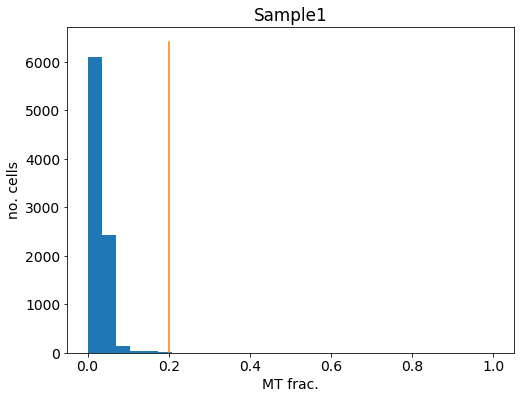

In [12]:
# plot mito-gene frac histograms - don't actually filter out any cells yet

# set mito-gene frac threshold
for j,s in enumerate(sample_list):
    D[s]['meta']['max_mt'] = 0.2

for j,s in enumerate(sample_list):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, xscale='linear', yscale='linear',
        xlabel='MT frac.', ylabel='no. cells')

    D[s]['mito_frac'] = np.sum(D[s]['E'][:,mt_ix], axis=1).A[:,0] / np.sum(D[s]['E'], axis=1,dtype=float).A[:,0]

    ax.hist(D[s]['mito_frac'], cumulative=False, 
            bins=np.linspace(0, 1, 30))

    ax.plot([D[s]['meta']['max_mt'],D[s]['meta']['max_mt']],ax.get_ylim());
    title(s)

    print D[s]['E'].shape[0], np.sum(D[s]['mito_frac'] <= D[s]['meta']['max_mt'])


In [13]:
# Actually filter out mito-high cells 
D_filt=D
for s in sample_list:
    print '---  %s ---' %s
    print 'Pre-filter: %i barcodes' %D[s]['E'].shape[0]
    tmpfilt = np.nonzero(D[s]['mito_frac'] <= D[s]['meta']['max_mt'])[0]
    D[s] = filter_dict(D[s], tmpfilt)
    print 'Post-filter: %i barcodes' %D[s]['E'].shape[0]
    
#del tmpfilt

---  Sample1 ---
Pre-filter: 8786 barcodes
Post-filter: 8758 barcodes


## Merge data, normalize

In [14]:
# create master dataset (all SPRING subsets will refer back to this)

samp_lookup = {}
samp_id_flat = np.array([],dtype=str)

for s in D.keys():
    samp_id_flat = np.append(samp_id_flat, [s] * D[s]['E'].shape[0])

        
E = scipy.sparse.lil_matrix((len(samp_id_flat), len(gene_list)), dtype=int)
total_counts = np.zeros(len(samp_id_flat), dtype=int)
mito_frac = np.zeros(len(samp_id_flat), dtype=float)
genes_detected = np.zeros(len(samp_id_flat), dtype=int)

for s in D.keys():
    print s
    E[samp_id_flat == s, :] = D[s]['E']
    total_counts[samp_id_flat == s] = D[s]['total_counts']
    mito_frac[samp_id_flat == s] = D[s]['mito_frac']
    genes_detected[samp_id_flat == s] = D[s]['genes_detected']

E = E.tocsc()

Sample1


In [15]:
E_full=E

In [16]:
# remove genes that are not expressed by any cells
# optionally remove mito and rps genes
gene_list = D[sample_list[0]]['meta']['gene_list']
gene_id = D[sample_list[0]]['meta']['gene_id']
remove_crapgenes = 1

if remove_crapgenes:
    import re
    mt_ix = [i for i,g in enumerate(gene_list) if g.startswith('MT-')]
    print [gene_list[i] for i in mt_ix]
    #rp_ix = [i for i,g in enumerate(gene_list) if g.startswith('RPS') or g.startswith('RPL')]
    #rp_ix = [i for i,g in enumerate(gene_list) if g.startswith('RPS','RPL')]
    rp_ix = [i for i,g in enumerate(gene_list) if g.startswith('RP1') 
             or g.startswith('RP2') or g.startswith('RP3')
             or g.startswith('RP4') or g.startswith('RP5')
             or g.startswith('RP6') or g.startswith('RP7')
             or g.startswith('RP8') or g.startswith('RP9')
             or g.startswith('RPL') or g.startswith('RPS')
            ]
    #or g.startswith('RP4','RP5','RP6') or g.startswith('RP7','RP8','RP9')]
    print [gene_list[i] for i in rp_ix]  
    keep_genes = (E.sum(0) > 0).A.squeeze() #* rp_ix * mt_ix
    print sum(keep_genes), '/', len(keep_genes)
    keep_genes[rp_ix] = 0
    print sum(keep_genes), '/', len(keep_genes)
    keep_genes[mt_ix] = 0
    print sum(keep_genes), '/', len(keep_genes)
else:
    keep_genes = (E.sum(0) > 0).A.squeeze()
    print sum(keep_genes), '/', len(keep_genes)


['MT-ND1', 'MT-ND2', 'MT-CO1', 'MT-CO2', 'MT-ATP8', 'MT-ATP6', 'MT-CO3', 'MT-ND3', 'MT-ND4L', 'MT-ND4', 'MT-ND5', 'MT-ND6', 'MT-CYB']
['RP11-34P13.3', 'RP11-34P13.7', 'RP11-34P13.8', 'RP11-34P13.14', 'RP11-34P13.9', 'RP5-857K21.15', 'RP4-669L17.2', 'RP4-669L17.10', 'RP5-857K21.4', 'RP5-857K21.2', 'RP11-206L10.4', 'RP11-206L10.9', 'RP11-54O7.16', 'RP11-54O7.1', 'RP11-54O7.2', 'RP11-54O7.3', 'RP11-54O7.17', 'RP11-54O7.11', 'RP11-54O7.18', 'RP11-465B22.8', 'RP5-902P8.12', 'RP5-902P8.10', 'RP4-758J18.13', 'RP4-758J18.7', 'RP4-758J18.10', 'RP5-832C2.5', 'RP11-345P4.9', 'RP11-345P4.10', 'RP11-345P4.7', 'RP1-140A9.1', 'RP11-547D24.1', 'RP11-547D24.3', 'RP5-892K4.1', 'RP11-181G12.2', 'RP11-181G12.4', 'RP3-395M20.2', 'RP3-395M20.3', 'RP3-395M20.12', 'RP3-395M20.8', 'RP3-395M20.9', 'RP13-436F16.1', 'RP11-740P5.2', 'RP11-740P5.3', 'RP1-163G9.2', 'RP11-22L13.1', 'RP11-168F9.2', 'RP11-46F15.2', 'RP5-1092A11.5', 'RP5-1092A11.2', 'RP1-286D6.5', 'RP13-614K11.2', 'RP5-1166F10.1', 'RP1-37J18.1', 'RP1-37

In [17]:
# normalize by total counts
E = E[:,keep_genes]
E = tot_counts_norm_sparse(E)[0]

In [18]:
print shape(E)
gene_list = gene_list[keep_genes]
gene_id = gene_id[keep_genes]
merged_list=[x+"_"+gene_id[i] for i,x in enumerate(gene_list)]

(8758, 18232)


## Save base directory files

In [19]:
main_spring_dir=os.getcwd()

if not os.path.exists(main_spring_dir):
    os.makedirs(main_spring_dir)

In [20]:
# Option to save the barcode information for later use
BCR = 1

if BCR:
    barcode_dir = main_spring_dir + "barcodes/"
    if not os.path.exists(barcode_dir):
        os.makedirs(barcode_dir)
        for s in sample_list:
            print '---  %s ---' %s
            np.savetxt(barcode_dir + s, D[s]['cell_index'], fmt='%s')


In [21]:
# option to save mitochondrial percentages for later use
MT = 1

if MT:
    MT_dir = main_spring_dir + "mito/"
    if not os.path.exists(MT_dir):
        os.makedirs(MT_dir)
        for s in sample_list:
            print '---  %s ---' %s
            np.savetxt(MT_dir + s, D[s]['mito_frac'], fmt='%s')

In [22]:
gene_list_new=np.array(merged_list)
np.savetxt(main_spring_dir + 'genes.txt', merged_list, fmt='%s')

In [23]:
# save master expression matrix in hdf5 format
import h5py

print 'Saving hdf5 file for fast gene loading...'
E = E.tocsc()
hf = h5py.File(main_spring_dir + 'counts_norm_sparse_genes.hdf5', 'w')
counts_group = hf.create_group('counts')
cix_group = hf.create_group('cell_ix')

hf.attrs['ncells'] = E.shape[0]
hf.attrs['ngenes'] = E.shape[1]

for iG, g in enumerate(merged_list):
    if iG % 3000 == 0:
        print g, iG, '/', len(merged_list)
    counts = E[:,iG].A.squeeze()
    cell_ix = np.nonzero(counts)[0]
    counts = counts[cell_ix]
    counts_group.create_dataset(g, data = counts)
    cix_group.create_dataset(g, data = cell_ix)

hf.close()

##############

print 'Saving hdf5 file for fast cell loading...'
E = E.tocsr()
hf = h5py.File(main_spring_dir + 'counts_norm_sparse_cells.hdf5', 'w')
counts_group = hf.create_group('counts')
gix_group = hf.create_group('gene_ix')

hf.attrs['ncells'] = E.shape[0]
hf.attrs['ngenes'] = E.shape[1]

for iC in range(E.shape[0]):
    if iC % 3000 == 0:
        print iC, '/', E.shape[0]
    counts = E[iC,:].A.squeeze()
    gene_ix = np.nonzero(counts)[0]
    counts = counts[gene_ix]
    
    counts_group.create_dataset(str(iC), data = counts)
    gix_group.create_dataset(str(iC), data = gene_ix)

hf.close()

Saving hdf5 file for fast gene loading...
FO538757.3_ENSG00000279928 0 / 18232
FAM132B_ENSG00000178752 3000 / 18232
SUPT3H_ENSG00000196284 6000 / 18232
MAPKAP1_ENSG00000119487 9000 / 18232
CCDC168_ENSG00000175820 12000 / 18232
KCNJ2_ENSG00000123700 15000 / 18232
MIR99AHG_ENSG00000215386 18000 / 18232
Saving hdf5 file for fast cell loading...
0 / 8758
3000 / 8758
6000 / 8758


In [24]:
scipy.io.mmwrite(main_spring_dir + 'matrix.mtx', E)

#### Save merged samples

['Sample1']
1612285718.26
________________ /FullDataset_v1
Filtering genes
Using 937 genes
Running PCA
Building kNN graph
kNN built in 6.11832 sec
Saving SPRING files to /home/I0369218/precision-immunology/CHAMBERLAIN.Mat/10X_PBMCs_Signac_GitHub/FullDataset_v1
Running ForceAtlas2
186.058496952
186.166760921


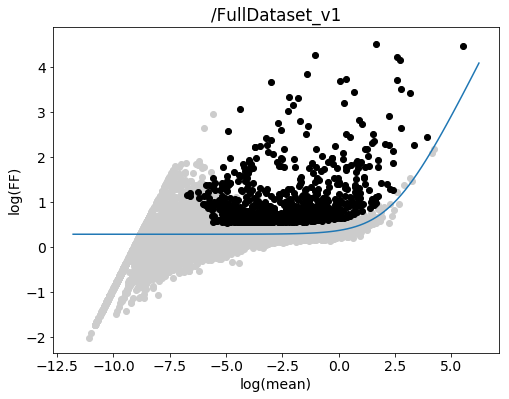

In [26]:
merge_setup = {'/FullDataset_v1':sample_list}

for s, smerge in merge_setup.items():
    print smerge
    t0 = time.time()
    print t0
    print '________________', s
    
    cell_ix = np.in1d(samp_id_flat, smerge)
    
    run_all_spring_1_6(E[cell_ix,:],
                     list(merged_list), s, main_spring_dir, normalize=False, tot_counts_final = total_counts[cell_ix],
                     min_counts = 3, min_cells = 3, min_vscore_pctl = 90, 
                     show_vscore_plot = True, num_pc = 60, pca_method = '', k_neigh=4, use_approxnn = False,
                     output_spring = True, num_force_iter = 2000,
                     cell_groupings = {'Sample': list(samp_id_flat[cell_ix])})
    
    print time.time() - t0
    
    np.save(main_spring_dir + s + '/cell_filter.npy', np.nonzero(cell_ix)[0])
    np.savetxt(main_spring_dir + s + '/cell_filter.txt', np.nonzero(cell_ix)[0], fmt='%i')
    
    print time.time() - t0


In [31]:
!Rscript signac.R 


RJSONIO      (NA        -> 1.3-1.4  ) [CRAN]
igraph       (1.2.4.2   -> 1.2.6    ) [CRAN]
jsonlite     (1.6.1     -> 1.7.2    ) [CRAN]
neuralnet    (NA        -> 1.44.2   ) [CRAN]
e1071        (NA        -> 1.7-4    ) [CRAN]
randomForest (NA        -> 4.6-14   ) [CRAN]
lme4         (NA        -> 1.1-26   ) [CRAN]
knitr        (NA        -> 1.31     ) [CRAN]
glasso       (NA        -> 1.11     ) [CRAN]
ggplot2      (3.2.1     -> 3.3.3    ) [CRAN]
slam         (0.1-47    -> 0.1-48   ) [CRAN]
docopt       (0.6.1     -> 0.7.1    ) [CRAN]
magrittr     (1.5       -> 2.0.1    ) [CRAN]
Deriv        (NA        -> 4.1.2    ) [CRAN]
minqa        (NA        -> 1.2.4    ) [CRAN]
nloptr       (NA        -> 1.2.2.2  ) [CRAN]
statmod      (NA        -> 1.4.35   ) [CRAN]
Rcpp         (1.0.3     -> 1.0.6    ) [CRAN]
RcppEigen    (0.3.3.7.0 -> 0.3.3.9.1) [CRAN]
highr        (NA        -> 0.8      ) [CRAN]
markdown     (NA        -> 1.1      ) [CRAN]
yaml         (2.2.0     -> 2.2.1    ) [CRAN]
xfun      

Content type 'application/x-gzip' length 1902568 bytes (1.8 MB)
downloaded 1.8 MB

trying URL 'https://cloud.r-project.org/src/contrib/rlang_0.4.10.tar.gz'
Content type 'application/x-gzip' length 915685 bytes (894 KB)
downloaded 894 KB

trying URL 'https://cloud.r-project.org/src/contrib/scales_1.1.1.tar.gz'
Content type 'application/x-gzip' length 515201 bytes (503 KB)
downloaded 503 KB

trying URL 'https://cloud.r-project.org/src/contrib/tibble_3.0.6.tar.gz'
Content type 'application/x-gzip' length 681013 bytes (665 KB)
downloaded 665 KB

trying URL 'https://cloud.r-project.org/src/contrib/withr_2.4.1.tar.gz'
Content type 'application/x-gzip' length 91901 bytes (89 KB)
downloaded 89 KB

trying URL 'https://cloud.r-project.org/src/contrib/mime_0.9.tar.gz'
Content type 'application/x-gzip' length 12843 bytes (12 KB)
downloaded 12 KB

trying URL 'https://cloud.r-project.org/src/contrib/stringi_1.5.3.tar.gz'
Content type 'application/x-gzip' length 7293930 bytes (7.0 MB)
downloaded 7.0 

g++ -std=gnu++11 -I"/usr/share/R/include" -DNDEBUG -I. -Ilibjson -Ilibjson/Source -DNEW_JSON_NEW_STREAM -DNDEBUG=1  -DJSON_VALIDATE -DJSON_STREAM=1 -DJSON_READ_PRIORITY=1 -DJSON_LIBRARY=1 -DJSON_ISO_STRICT    -fpic  -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c JSONIterators.cpp -o JSONIterators.o
g++ -std=gnu++11 -I"/usr/share/R/include" -DNDEBUG -I. -Ilibjson -Ilibjson/Source -DNEW_JSON_NEW_STREAM -DNDEBUG=1  -DJSON_VALIDATE -DJSON_STREAM=1 -DJSON_READ_PRIORITY=1 -DJSON_LIBRARY=1 -DJSON_ISO_STRICT    -fpic  -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c JSONMemory.cpp -o JSONMemory.o
g++ -std=gnu++11 -I"/usr/share/R/include" -DNDEBUG -I. -Ilibjson -Ilibjson/Source -DNEW_JSON_NEW_STREAM -DNDEBUG=1  -DJSON_VALIDATE -DJSON_STREAM=1 -DJSON_READ_PRIORITY=1 -DJSON_LIBRARY=1 -DJSON_ISO_STRICT    -fpic  -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time

gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG -Iyajl/api   -fvisibility=hidden  -fpic  -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c is_recordlist.c -o is_recordlist.o
gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG -Iyajl/api   -fvisibility=hidden  -fpic  -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c is_scalarlist.c -o is_scalarlist.o
gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG -Iyajl/api   -fvisibility=hidden  -fpic  -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c modp_numtoa.c -o modp_numtoa.o
gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG -Iyajl/api   -fvisibility=hidden  -fpic  -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c null_to_na.c -o null_to_na.o
gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG -Iyajl/api   -fvisibility=hidden  -fpic  -g -

* installing *source* package 'randomForest' ...
** package 'randomForest' successfully unpacked and MD5 sums checked
** using staged installation
** libs
gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG     -fpic  -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c classTree.c -o classTree.o
gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG     -fpic  -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c init.c -o init.o
gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG     -fpic  -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c regTree.c -o regTree.o
gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG     -fpic  -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c regrf.c -o regrf.o
gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG     -fpic  -g -O2 -fstack-protector-strong -Wformat -W

checking for unistd.h... yes
checking nlopt.h usability... no
checking nlopt.h presence... no
checking for nlopt.h... no
configure: Need to configure and build NLopt
configure: Starting to install library to /tmp/RtmppxUstt/R.INSTALLe0416914831/nloptr/src/nlopt_src
checking for a BSD-compatible install... /usr/bin/install -c
checking whether build environment is sane... yes
checking for a thread-safe mkdir -p... /bin/mkdir -p
checking for gawk... no
checking for mawk... mawk
checking whether make sets $(MAKE)... yes
checking whether make supports nested variables... yes
checking whether to enable maintainer-specific portions of Makefiles... no
checking for gcc... gcc -std=gnu99
checking whether the C compiler works... yes
checking for C compiler default output file name... a.out
checking for suffix of executables... 
checking whether we are cross compiling... no
checking for suffix of object files... o
checking whether we are using the GNU C compiler... yes
checking whether gcc -std=gn

mv -f .deps/mt19937ar.Tpo .deps/mt19937ar.Plo
/bin/sh ../libtool  --tag=CC   --mode=compile g++ -std=gnu++11 -DHAVE_CONFIG_H -I. -I..  -I../api   -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -MT sobolseq.lo -MD -MP -MF .deps/sobolseq.Tpo -c -o sobolseq.lo sobolseq.c
libtool: compile:  g++ -std=gnu++11 -DHAVE_CONFIG_H -I. -I.. -I../api -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -MT sobolseq.lo -MD -MP -MF .deps/sobolseq.Tpo -c sobolseq.c  -fPIC -DPIC -o .libs/sobolseq.o
libtool: compile:  g++ -std=gnu++11 -DHAVE_CONFIG_H -I. -I.. -I../api -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -MT sobolseq.lo -MD -MP -MF .deps/sobolseq.Tpo -c sobolseq.c -o sobolseq.o >/dev/null 2>&1
mv -f .deps/sobolseq.Tpo .deps/sobolseq.Plo
/bin/sh ../libtool  --tag=CC   --mode=compile g++ -std=gnu++11 -DHAVE_CONFIG_H -I. -I..  -I../api   -g -O2 -f

mv -f .deps/direct_wrap.Tpo .deps/direct_wrap.Plo
/bin/sh ../libtool  --tag=CC   --mode=compile g++ -std=gnu++11 -DHAVE_CONFIG_H -I. -I..  -I../util -I../api   -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -MT DIRserial.lo -MD -MP -MF .deps/DIRserial.Tpo -c -o DIRserial.lo DIRserial.c
libtool: compile:  g++ -std=gnu++11 -DHAVE_CONFIG_H -I. -I.. -I../util -I../api -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -MT DIRserial.lo -MD -MP -MF .deps/DIRserial.Tpo -c DIRserial.c  -fPIC -DPIC -o .libs/DIRserial.o
libtool: compile:  g++ -std=gnu++11 -DHAVE_CONFIG_H -I. -I.. -I../util -I../api -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -MT DIRserial.lo -MD -MP -MF .deps/DIRserial.Tpo -c DIRserial.c -o DIRserial.o >/dev/null 2>&1
mv -f .deps/DIRserial.Tpo .deps/DIRserial.Plo
/bin/sh ../libtool  --tag=CC   --mode=compile g++ -std=gnu++1

libtool: compile:  g++ -std=gnu++11 -DHAVE_CONFIG_H -I. -I.. -I../util -I../api -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -MT linalg.lo -MD -MP -MF .deps/linalg.Tpo -c linalg.cc  -fPIC -DPIC -o .libs/linalg.o
libtool: compile:  g++ -std=gnu++11 -DHAVE_CONFIG_H -I. -I.. -I../util -I../api -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -MT linalg.lo -MD -MP -MF .deps/linalg.Tpo -c linalg.cc -o linalg.o >/dev/null 2>&1
mv -f .deps/linalg.Tpo .deps/linalg.Plo
/bin/sh ../libtool  --tag=CXX   --mode=compile g++ -std=gnu++11 -DHAVE_CONFIG_H -I. -I..  -I../util -I../api   -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -MT local.lo -MD -MP -MF .deps/local.Tpo -c -o local.lo local.cc
libtool: compile:  g++ -std=gnu++11 -DHAVE_CONFIG_H -I. -I.. -I../util -I../api -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-t

libtool: compile:  g++ -std=gnu++11 -DHAVE_CONFIG_H -I. -I.. -I../util -I../api -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -MT mssubs.lo -MD -MP -MF .deps/mssubs.Tpo -c mssubs.c -o mssubs.o >/dev/null 2>&1
mv -f .deps/mssubs.Tpo .deps/mssubs.Plo
/bin/sh ../libtool  --tag=CC   --mode=compile g++ -std=gnu++11 -DHAVE_CONFIG_H -I. -I..  -I../util -I../api   -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -MT pssubs.lo -MD -MP -MF .deps/pssubs.Tpo -c -o pssubs.lo pssubs.c
libtool: compile:  g++ -std=gnu++11 -DHAVE_CONFIG_H -I. -I.. -I../util -I../api -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -MT pssubs.lo -MD -MP -MF .deps/pssubs.Tpo -c pssubs.c  -fPIC -DPIC -o .libs/pssubs.o
libtool: compile:  g++ -std=gnu++11 -DHAVE_CONFIG_H -I. -I.. -I../util -I../api -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-t

libtool: link: ar cru .libs/libcobyla.a .libs/cobyla.o 
ar: `u' modifier ignored since `D' is the default (see `U')
libtool: link: ranlib .libs/libcobyla.a
libtool: link: ( cd ".libs" && rm -f "libcobyla.la" && ln -s "../libcobyla.la" "libcobyla.la" )
make[2]: Leaving directory '/tmp/RtmppxUstt/R.INSTALLe0416914831/nloptr/src/nlopt_src/cobyla'
Making all in newuoa
make[2]: Entering directory '/tmp/RtmppxUstt/R.INSTALLe0416914831/nloptr/src/nlopt_src/newuoa'
/bin/sh ../libtool  --tag=CC   --mode=compile g++ -std=gnu++11 -DHAVE_CONFIG_H -I. -I..  -I../util -I../api   -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -MT newuoa.lo -MD -MP -MF .deps/newuoa.Tpo -c -o newuoa.lo newuoa.c
libtool: compile:  g++ -std=gnu++11 -DHAVE_CONFIG_H -I. -I.. -I../util -I../api -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -MT newuoa.lo -MD -MP -MF .deps/newuoa.Tpo -c newuoa.c  -fPIC -DPIC -o .libs/new

libtool: compile:  g++ -std=gnu++11 -DHAVE_CONFIG_H -I. -I.. -I../util -I../api -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -MT sbplx.lo -MD -MP -MF .deps/sbplx.Tpo -c sbplx.c -o sbplx.o >/dev/null 2>&1
mv -f .deps/sbplx.Tpo .deps/sbplx.Plo
/bin/sh ../libtool  --tag=CC   --mode=link g++ -std=gnu++11  -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g   -o libneldermead.la  nldrmd.lo sbplx.lo  -lm 
libtool: link: ar cru .libs/libneldermead.a .libs/nldrmd.o .libs/sbplx.o 
ar: `u' modifier ignored since `D' is the default (see `U')
libtool: link: ranlib .libs/libneldermead.a
libtool: link: ( cd ".libs" && rm -f "libneldermead.la" && ln -s "../libneldermead.la" "libneldermead.la" )
make[2]: Leaving directory '/tmp/RtmppxUstt/R.INSTALLe0416914831/nloptr/src/nlopt_src/neldermead'
Making all in auglag
make[2]: Entering directory '/tmp/RtmppxUstt/R.INSTALLe0416914831/nloptr/src/nlopt_src/au

libtool: compile:  g++ -std=gnu++11 -DHAVE_CONFIG_H -I. -I.. -I../cdirect -I../direct -I../stogo -I../praxis -I../lbfgs -I../luksan -I../crs -I../mlsl -I../mma -I../cobyla -I../newuoa -I../neldermead -I../auglag -I../bobyqa -I../isres -I../slsqp -I../esch -I../util -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -MT general.lo -MD -MP -MF .deps/general.Tpo -c general.c  -fPIC -DPIC -o .libs/general.o
libtool: compile:  g++ -std=gnu++11 -DHAVE_CONFIG_H -I. -I.. -I../cdirect -I../direct -I../stogo -I../praxis -I../lbfgs -I../luksan -I../crs -I../mlsl -I../mma -I../cobyla -I../newuoa -I../neldermead -I../auglag -I../bobyqa -I../isres -I../slsqp -I../esch -I../util -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -MT general.lo -MD -MP -MF .deps/general.Tpo -c general.c -o general.o >/dev/null 2>&1
mv -f .deps/general.Tpo .deps/general.Plo
/bin/sh ../libtool  --tag=CC   --mode=compile g++

libtool: compile:  g++ -std=gnu++11 -DHAVE_CONFIG_H -I. -I.. -I../cdirect -I../direct -I../stogo -I../praxis -I../lbfgs -I../luksan -I../crs -I../mlsl -I../mma -I../cobyla -I../newuoa -I../neldermead -I../auglag -I../bobyqa -I../isres -I../slsqp -I../esch -I../util -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -MT deprecated.lo -MD -MP -MF .deps/deprecated.Tpo -c deprecated.c -o deprecated.o >/dev/null 2>&1
mv -f .deps/deprecated.Tpo .deps/deprecated.Plo
/bin/sh ../libtool  --tag=CC   --mode=compile g++ -std=gnu++11 -DHAVE_CONFIG_H -I. -I..  -I../cdirect -I../direct -I../stogo -I../praxis -I../lbfgs -I../luksan -I../crs -I../mlsl -I../mma -I../cobyla -I../newuoa -I../neldermead -I../auglag -I../bobyqa -I../isres -I../slsqp -I../esch -I../util   -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -MT f77api.lo -MD -MP -MF .deps/f77api.Tpo -c -o f77api.lo f77api.c
libtool: compile:  g++ 

libtool: compile:  g++ -std=gnu++11 -DHAVE_CONFIG_H -I. -I.. -I../cdirect -I../direct -I../stogo -I../praxis -I../lbfgs -I../luksan -I../crs -I../mlsl -I../mma -I../cobyla -I../newuoa -I../neldermead -I../auglag -I../bobyqa -I../isres -I../slsqp -I../esch -I../util -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -MT f77api.lo -MD -MP -MF .deps/f77api.Tpo -c f77api.c -o f77api.o >/dev/null 2>&1
mv -f .deps/f77api.Tpo .deps/f77api.Plo
/bin/sh ../libtool  --tag=CC   --mode=link g++ -std=gnu++11  -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g   -o libapi.la  general.lo options.lo optimize.lo deprecated.lo f77api.lo  -lm 
libtool: link: ar cru .libs/libapi.a .libs/general.o .libs/options.o .libs/optimize.o .libs/deprecated.o .libs/f77api.o 
ar: `u' modifier ignored since `D' is the default (see `U')
libtool: link: ranlib .libs/libapi.a
libtool: link: ( cd ".libs" && rm -f "libapi.la" && 

libtool: link: g++ -std=gnu++11 -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -o dummy dummy.o  -lm
make[3]: Leaving directory '/tmp/RtmppxUstt/R.INSTALLe0416914831/nloptr/src/nlopt_src/octave'
make[2]: Leaving directory '/tmp/RtmppxUstt/R.INSTALLe0416914831/nloptr/src/nlopt_src/octave'
Making all in test
make[2]: Entering directory '/tmp/RtmppxUstt/R.INSTALLe0416914831/nloptr/src/nlopt_src/test'
g++ -std=gnu++11 -DHAVE_CONFIG_H -I. -I..  -I../api -I../util   -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -MT testfuncs.o -MD -MP -MF .deps/testfuncs.Tpo -c -o testfuncs.o testfuncs.c
mv -f .deps/testfuncs.Tpo .deps/testfuncs.Po
g++ -std=gnu++11 -DHAVE_CONFIG_H -I. -I..  -I../api -I../util   -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -MT testopt.o -MD -MP -MF .deps/testopt.Tpo -c -o testopt.o testopt.cpp
testopt.cpp: In functio

make[1]: Entering directory '/tmp/RtmppxUstt/R.INSTALLe0416914831/nloptr/src/nlopt_src/auglag'
make[2]: Entering directory '/tmp/RtmppxUstt/R.INSTALLe0416914831/nloptr/src/nlopt_src/auglag'
make[2]: Nothing to be done for 'install-exec-am'.
make[2]: Nothing to be done for 'install-data-am'.
make[2]: Leaving directory '/tmp/RtmppxUstt/R.INSTALLe0416914831/nloptr/src/nlopt_src/auglag'
make[1]: Leaving directory '/tmp/RtmppxUstt/R.INSTALLe0416914831/nloptr/src/nlopt_src/auglag'
Making install in bobyqa
make[1]: Entering directory '/tmp/RtmppxUstt/R.INSTALLe0416914831/nloptr/src/nlopt_src/bobyqa'
make[2]: Entering directory '/tmp/RtmppxUstt/R.INSTALLe0416914831/nloptr/src/nlopt_src/bobyqa'
make[2]: Nothing to be done for 'install-exec-am'.
make[2]: Nothing to be done for 'install-data-am'.
make[2]: Leaving directory '/tmp/RtmppxUstt/R.INSTALLe0416914831/nloptr/src/nlopt_src/bobyqa'
make[1]: Leaving directory '/tmp/RtmppxUstt/R.INSTALLe0416914831/nloptr/src/nlopt_src/bobyqa'
Making install 

gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG    -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -I/tmp/RtmppxUstt/R.INSTALLe0416914831/nloptr/src/nlopt_src/include -fpic  -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c nloptr.c -o nloptr.o
g++ -std=gnu++11 -shared -L/usr/lib/R/lib -Wl,-Bsymbolic-functions -Wl,-z,relro -o nloptr.so dummy.o init_nloptr.o nloptr.o -lm -lm /tmp/RtmppxUstt/R.INSTALLe0416914831/nloptr/src/nlopt_src/lib/libnlopt_cxx.a -L/usr/lib/R/lib -lR
installing to /usr/local/lib/R/site-library/00LOCK-nloptr/00new/nloptr/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from

gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG     -fpic  -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c init.c -o init.o
g++ -std=gnu++11 -shared -L/usr/lib/R/lib -Wl,-Bsymbolic-functions -Wl,-z,relro -o xfun.so base64.o init.o -L/usr/lib/R/lib -lR
installing to /usr/local/lib/R/site-library/00LOCK-xfun/00new/xfun/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (xfun)
* installing *source* package 'digest' ...
** package 'digest' successfully unpacked and MD5 sums checked
** using staged installation
** libs
g++ -std=gnu++11 -I"/usr/sh

* installing *source* package 'withr' ...
** package 'withr' successfully unpacked and MD5 sums checked
** using staged installation
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (withr)
* installing *source* package 'mime' ...
** package 'mime' successfully unpacked and MD5 sums checked
** using staged installation
** libs
gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG     -fpic  -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c init.c -o init.o
gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG     -fpic  -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORT

g++ -std=gnu++11 -I"/usr/share/R/include" -DNDEBUG -I. -I/usr/include/x86_64-linux-gnu   -UDEBUG -DNDEBUG -DU_HAVE_ELF_H   -fpic -fpic  -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c stri_container_utf8.cpp -o stri_container_utf8.o
g++ -std=gnu++11 -I"/usr/share/R/include" -DNDEBUG -I. -I/usr/include/x86_64-linux-gnu   -UDEBUG -DNDEBUG -DU_HAVE_ELF_H   -fpic -fpic  -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c stri_container_utf8_indexable.cpp -o stri_container_utf8_indexable.o
g++ -std=gnu++11 -I"/usr/share/R/include" -DNDEBUG -I. -I/usr/include/x86_64-linux-gnu   -UDEBUG -DNDEBUG -DU_HAVE_ELF_H   -fpic -fpic  -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c stri_encoding_conversion.cpp -o stri_encoding_conversion.o
g++ -std=gnu++11 -I"/usr/share/R/include" -DNDEBUG -I. -I/usr/include/x86_64-linux-gnu   -UDEBUG -DNDEB

g++ -std=gnu++11 -I"/usr/share/R/include" -DNDEBUG -I. -I/usr/include/x86_64-linux-gnu   -UDEBUG -DNDEBUG -DU_HAVE_ELF_H   -fpic -fpic  -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c stri_search_coll_split.cpp -o stri_search_coll_split.o
g++ -std=gnu++11 -I"/usr/share/R/include" -DNDEBUG -I. -I/usr/include/x86_64-linux-gnu   -UDEBUG -DNDEBUG -DU_HAVE_ELF_H   -fpic -fpic  -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c stri_search_coll_startsendswith.cpp -o stri_search_coll_startsendswith.o
g++ -std=gnu++11 -I"/usr/share/R/include" -DNDEBUG -I. -I/usr/include/x86_64-linux-gnu   -UDEBUG -DNDEBUG -DU_HAVE_ELF_H   -fpic -fpic  -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c stri_search_coll_subset.cpp -o stri_search_coll_subset.o
g++ -std=gnu++11 -I"/usr/share/R/include" -DNDEBUG -I. -I/usr/include/x86_64-linux-gnu   -UDEBU

g++ -std=gnu++11 -I"/usr/share/R/include" -DNDEBUG -I. -I/usr/include/x86_64-linux-gnu   -UDEBUG -DNDEBUG -DU_HAVE_ELF_H   -fpic -fpic  -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c stri_sub.cpp -o stri_sub.o
g++ -std=gnu++11 -I"/usr/share/R/include" -DNDEBUG -I. -I/usr/include/x86_64-linux-gnu   -UDEBUG -DNDEBUG -DU_HAVE_ELF_H   -fpic -fpic  -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c stri_test.cpp -o stri_test.o
g++ -std=gnu++11 -I"/usr/share/R/include" -DNDEBUG -I. -I/usr/include/x86_64-linux-gnu   -UDEBUG -DNDEBUG -DU_HAVE_ELF_H   -fpic -fpic  -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c stri_time_zone.cpp -o stri_time_zone.o
g++ -std=gnu++11 -I"/usr/share/R/include" -DNDEBUG -I. -I/usr/include/x86_64-linux-gnu   -UDEBUG -DNDEBUG -DU_HAVE_ELF_H   -fpic -fpic  -g -O2 -fstack-protector-strong -Wformat -Werror=

gcc -std=gnu99 -shared -L/usr/lib/R/lib -Wl,-Bsymbolic-functions -Wl,-z,relro -o brio.so brio.o file_line_endings.o init.o read_file.o read_file_raw.o read_lines.o write_file.o write_lines.o -L/usr/lib/R/lib -lR
installing to /usr/local/lib/R/site-library/00LOCK-brio/00new/brio/libs
** R
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (brio)
* installing *source* package 'crayon' ...
** package 'crayon' successfully unpacked and MD5 sums checked
** using staged installation
** R
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loa

gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG     -fpic  -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c utils.c -o utils.o
gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG     -fpic  -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c wrap.c -o wrap.o
gcc -std=gnu99 -shared -L/usr/lib/R/lib -Wl,-Bsymbolic-functions -Wl,-z,relro -o fansi.so assumptions.o has.o init.o nchar.o read.o rnchar.o state.o strip.o strsplit.o tabs.o tohtml.o unhandled.o unique.o utf8.o utils.o wrap.o -L/usr/lib/R/lib -lR
installing to /usr/local/lib/R/site-library/00LOCK-fansi/00new/fansi/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed

gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG    -DUSING_R -I. -Iinclude -Ics -Iplfit -ICHOLMOD/Include -IAMD/Include -ICOLAMD/Include -ISuiteSparse_config -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -I/opt/local/anaconda2/include/libxml2 -I/opt/local/anaconda2/include -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -I/opt/local/anaconda2/include/libxml2 -I/opt/local/anaconda2/include -DNDEBUG -DNPARTITION -DNTIMER -DNCAMD -DNPRINT -DPACKAGE_VERSION=\"1.2.6\" -DINTERNAL_ARPACK -DIGRAPH_THREAD_LOCAL=/**/ -fpic  -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c AMD/Source/amd_control.c -o AMD/Source/amd_control.o
gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG    -DUSING_R -I. -Iinclude -Ics -Iplfit -ICHOLMOD/Include -IAMD/Include -ICOLAMD/Include -ISuiteSparse_config -g -O2 -fstack-protector-strong -Wformat -Werror=format-s

gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG    -DUSING_R -I. -Iinclude -Ics -Iplfit -ICHOLMOD/Include -IAMD/Include -ICOLAMD/Include -ISuiteSparse_config -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -I/opt/local/anaconda2/include/libxml2 -I/opt/local/anaconda2/include -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -I/opt/local/anaconda2/include/libxml2 -I/opt/local/anaconda2/include -DNDEBUG -DNPARTITION -DNTIMER -DNCAMD -DNPRINT -DPACKAGE_VERSION=\"1.2.6\" -DINTERNAL_ARPACK -DIGRAPH_THREAD_LOCAL=/**/ -fpic  -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c CHOLMOD/Check/cholmod_read.c -o CHOLMOD/Check/cholmod_read.o
gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG    -DUSING_R -I. -Iinclude -Ics -Iplfit -ICHOLMOD/Include -IAMD/Include -ICOLAMD/Include -ISuiteSparse_config -g -O2 -fstack-protector-strong -Wformat -Werror=

gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG    -DUSING_R -I. -Iinclude -Ics -Iplfit -ICHOLMOD/Include -IAMD/Include -ICOLAMD/Include -ISuiteSparse_config -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -I/opt/local/anaconda2/include/libxml2 -I/opt/local/anaconda2/include -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -I/opt/local/anaconda2/include/libxml2 -I/opt/local/anaconda2/include -DNDEBUG -DNPARTITION -DNTIMER -DNCAMD -DNPRINT -DPACKAGE_VERSION=\"1.2.6\" -DINTERNAL_ARPACK -DIGRAPH_THREAD_LOCAL=/**/ -fpic  -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c CHOLMOD/Cholesky/cholmod_rowfac.c -o CHOLMOD/Cholesky/cholmod_rowfac.o
gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG    -DUSING_R -I. -Iinclude -Ics -Iplfit -ICHOLMOD/Include -IAMD/Include -ICOLAMD/Include -ISuiteSparse_config -g -O2 -fstack-protector-strong -Wforma

gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG    -DUSING_R -I. -Iinclude -Ics -Iplfit -ICHOLMOD/Include -IAMD/Include -ICOLAMD/Include -ISuiteSparse_config -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -I/opt/local/anaconda2/include/libxml2 -I/opt/local/anaconda2/include -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -I/opt/local/anaconda2/include/libxml2 -I/opt/local/anaconda2/include -DNDEBUG -DNPARTITION -DNTIMER -DNCAMD -DNPRINT -DPACKAGE_VERSION=\"1.2.6\" -DINTERNAL_ARPACK -DIGRAPH_THREAD_LOCAL=/**/ -fpic  -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c CHOLMOD/Core/cholmod_error.c -o CHOLMOD/Core/cholmod_error.o
gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG    -DUSING_R -I. -Iinclude -Ics -Iplfit -ICHOLMOD/Include -IAMD/Include -ICOLAMD/Include -ISuiteSparse_config -g -O2 -fstack-protector-strong -Wformat -Werror=

gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG    -DUSING_R -I. -Iinclude -Ics -Iplfit -ICHOLMOD/Include -IAMD/Include -ICOLAMD/Include -ISuiteSparse_config -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -I/opt/local/anaconda2/include/libxml2 -I/opt/local/anaconda2/include -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -I/opt/local/anaconda2/include/libxml2 -I/opt/local/anaconda2/include -DNDEBUG -DNPARTITION -DNTIMER -DNCAMD -DNPRINT -DPACKAGE_VERSION=\"1.2.6\" -DINTERNAL_ARPACK -DIGRAPH_THREAD_LOCAL=/**/ -fpic  -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c CHOLMOD/MatrixOps/cholmod_sdmult.c -o CHOLMOD/MatrixOps/cholmod_sdmult.o
gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG    -DUSING_R -I. -Iinclude -Ics -Iplfit -ICHOLMOD/Include -IAMD/Include -ICOLAMD/Include -ISuiteSparse_config -g -O2 -fstack-protector-strong -Wfor

gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG    -DUSING_R -I. -Iinclude -Ics -Iplfit -ICHOLMOD/Include -IAMD/Include -ICOLAMD/Include -ISuiteSparse_config -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -I/opt/local/anaconda2/include/libxml2 -I/opt/local/anaconda2/include -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -I/opt/local/anaconda2/include/libxml2 -I/opt/local/anaconda2/include -DNDEBUG -DNPARTITION -DNTIMER -DNCAMD -DNPRINT -DPACKAGE_VERSION=\"1.2.6\" -DINTERNAL_ARPACK -DIGRAPH_THREAD_LOCAL=/**/ -fpic  -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c CHOLMOD/Partition/cholmod_metis.c -o CHOLMOD/Partition/cholmod_metis.o
gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG    -DUSING_R -I. -Iinclude -Ics -Iplfit -ICHOLMOD/Include -IAMD/Include -ICOLAMD/Include -ISuiteSparse_config -g -O2 -fstack-protector-strong -Wforma

gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG    -DUSING_R -I. -Iinclude -Ics -Iplfit -ICHOLMOD/Include -IAMD/Include -ICOLAMD/Include -ISuiteSparse_config -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -I/opt/local/anaconda2/include/libxml2 -I/opt/local/anaconda2/include -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -I/opt/local/anaconda2/include/libxml2 -I/opt/local/anaconda2/include -DNDEBUG -DNPARTITION -DNTIMER -DNCAMD -DNPRINT -DPACKAGE_VERSION=\"1.2.6\" -DINTERNAL_ARPACK -DIGRAPH_THREAD_LOCAL=/**/ -fpic  -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c arpack.c -o arpack.o
gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG    -DUSING_R -I. -Iinclude -Ics -Iplfit -ICHOLMOD/Include -IAMD/Include -ICOLAMD/Include -ISuiteSparse_config -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_S

g++ -std=gnu++11 -I"/usr/share/R/include" -DNDEBUG    -DUSING_R -DIGRAPH_THREAD_LOCAL=/**/ -DNDEBUG -Iprpack -I. -Iinclude -DPRPACK_IGRAPH_SUPPORT -fpic  -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c bliss/graph.cc -o bliss/graph.o
g++ -std=gnu++11 -I"/usr/share/R/include" -DNDEBUG    -DUSING_R -DIGRAPH_THREAD_LOCAL=/**/ -DNDEBUG -Iprpack -I. -Iinclude -DPRPACK_IGRAPH_SUPPORT -fpic  -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c bliss/orbit.cc -o bliss/orbit.o
g++ -std=gnu++11 -I"/usr/share/R/include" -DNDEBUG    -DUSING_R -DIGRAPH_THREAD_LOCAL=/**/ -DNDEBUG -Iprpack -I. -Iinclude -DPRPACK_IGRAPH_SUPPORT -fpic  -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c bliss/partition.cc -o bliss/partition.o
g++ -std=gnu++11 -I"/usr/share/R/include" -DNDEBUG    -DUSING_R -DIGRAPH_THREAD_LOCAL=/**/ -DNDEBUG -Iprpack -I. -Iinclude

gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG    -DUSING_R -I. -Iinclude -Ics -Iplfit -ICHOLMOD/Include -IAMD/Include -ICOLAMD/Include -ISuiteSparse_config -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -I/opt/local/anaconda2/include/libxml2 -I/opt/local/anaconda2/include -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -I/opt/local/anaconda2/include/libxml2 -I/opt/local/anaconda2/include -DNDEBUG -DNPARTITION -DNTIMER -DNCAMD -DNPRINT -DPACKAGE_VERSION=\"1.2.6\" -DINTERNAL_ARPACK -DIGRAPH_THREAD_LOCAL=/**/ -fpic  -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c community.c -o community.o
gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG    -DUSING_R -I. -Iinclude -Ics -Iplfit -ICHOLMOD/Include -IAMD/Include -ICOLAMD/Include -ISuiteSparse_config -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FOR

gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG    -DUSING_R -I. -Iinclude -Ics -Iplfit -ICHOLMOD/Include -IAMD/Include -ICOLAMD/Include -ISuiteSparse_config -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -I/opt/local/anaconda2/include/libxml2 -I/opt/local/anaconda2/include -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -I/opt/local/anaconda2/include/libxml2 -I/opt/local/anaconda2/include -DNDEBUG -DNPARTITION -DNTIMER -DNCAMD -DNPRINT -DPACKAGE_VERSION=\"1.2.6\" -DINTERNAL_ARPACK -DIGRAPH_THREAD_LOCAL=/**/ -fpic  -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c cs/cs_cumsum.c -o cs/cs_cumsum.o
gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG    -DUSING_R -I. -Iinclude -Ics -Iplfit -ICHOLMOD/Include -IAMD/Include -ICOLAMD/Include -ISuiteSparse_config -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time 

gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG    -DUSING_R -I. -Iinclude -Ics -Iplfit -ICHOLMOD/Include -IAMD/Include -ICOLAMD/Include -ISuiteSparse_config -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -I/opt/local/anaconda2/include/libxml2 -I/opt/local/anaconda2/include -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -I/opt/local/anaconda2/include/libxml2 -I/opt/local/anaconda2/include -DNDEBUG -DNPARTITION -DNTIMER -DNCAMD -DNPRINT -DPACKAGE_VERSION=\"1.2.6\" -DINTERNAL_ARPACK -DIGRAPH_THREAD_LOCAL=/**/ -fpic  -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c cs/cs_happly.c -o cs/cs_happly.o
gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG    -DUSING_R -I. -Iinclude -Ics -Iplfit -ICHOLMOD/Include -IAMD/Include -ICOLAMD/Include -ISuiteSparse_config -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time 

gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG    -DUSING_R -I. -Iinclude -Ics -Iplfit -ICHOLMOD/Include -IAMD/Include -ICOLAMD/Include -ISuiteSparse_config -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -I/opt/local/anaconda2/include/libxml2 -I/opt/local/anaconda2/include -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -I/opt/local/anaconda2/include/libxml2 -I/opt/local/anaconda2/include -DNDEBUG -DNPARTITION -DNTIMER -DNCAMD -DNPRINT -DPACKAGE_VERSION=\"1.2.6\" -DINTERNAL_ARPACK -DIGRAPH_THREAD_LOCAL=/**/ -fpic  -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c cs/cs_multiply.c -o cs/cs_multiply.o
gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG    -DUSING_R -I. -Iinclude -Ics -Iplfit -ICHOLMOD/Include -IAMD/Include -ICOLAMD/Include -ISuiteSparse_config -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-t

gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG    -DUSING_R -I. -Iinclude -Ics -Iplfit -ICHOLMOD/Include -IAMD/Include -ICOLAMD/Include -ISuiteSparse_config -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -I/opt/local/anaconda2/include/libxml2 -I/opt/local/anaconda2/include -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -I/opt/local/anaconda2/include/libxml2 -I/opt/local/anaconda2/include -DNDEBUG -DNPARTITION -DNTIMER -DNCAMD -DNPRINT -DPACKAGE_VERSION=\"1.2.6\" -DINTERNAL_ARPACK -DIGRAPH_THREAD_LOCAL=/**/ -fpic  -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c cs/cs_scatter.c -o cs/cs_scatter.o
gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG    -DUSING_R -I. -Iinclude -Ics -Iplfit -ICHOLMOD/Include -IAMD/Include -ICOLAMD/Include -ISuiteSparse_config -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-tim

gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG    -DUSING_R -I. -Iinclude -Ics -Iplfit -ICHOLMOD/Include -IAMD/Include -ICOLAMD/Include -ISuiteSparse_config -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -I/opt/local/anaconda2/include/libxml2 -I/opt/local/anaconda2/include -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -I/opt/local/anaconda2/include/libxml2 -I/opt/local/anaconda2/include -DNDEBUG -DNPARTITION -DNTIMER -DNCAMD -DNPRINT -DPACKAGE_VERSION=\"1.2.6\" -DINTERNAL_ARPACK -DIGRAPH_THREAD_LOCAL=/**/ -fpic  -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c cs/cs_utsolve.c -o cs/cs_utsolve.o
gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG    -DUSING_R -I. -Iinclude -Ics -Iplfit -ICHOLMOD/Include -IAMD/Include -ICOLAMD/Include -ISuiteSparse_config -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-tim

gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG    -DUSING_R -I. -Iinclude -Ics -Iplfit -ICHOLMOD/Include -IAMD/Include -ICOLAMD/Include -ISuiteSparse_config -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -I/opt/local/anaconda2/include/libxml2 -I/opt/local/anaconda2/include -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -I/opt/local/anaconda2/include/libxml2 -I/opt/local/anaconda2/include -DNDEBUG -DNPARTITION -DNTIMER -DNCAMD -DNPRINT -DPACKAGE_VERSION=\"1.2.6\" -DINTERNAL_ARPACK -DIGRAPH_THREAD_LOCAL=/**/ -fpic  -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c flow.c -o flow.o
gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG    -DUSING_R -I. -Iinclude -Ics -Iplfit -ICHOLMOD/Include -IAMD/Include -ICOLAMD/Include -ISuiteSparse_config -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURC

In file included from src/foreign-ncol-parser.y:49:0:
igraph_hacks_internal.h:42:0: warning: "strdup" redefined
 #  define strdup igraph_i_strdup
 ^
In file included from /usr/include/string.h:630:0,
                 from src/foreign-ncol-parser.y:48:
/usr/include/x86_64-linux-gnu/bits/string2.h:1291:0: note: this is the location of the previous definition
 #   define strdup(s) __strdup (s)
 ^
gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG    -DUSING_R -I. -Iinclude -Ics -Iplfit -ICHOLMOD/Include -IAMD/Include -ICOLAMD/Include -ISuiteSparse_config -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -I/opt/local/anaconda2/include/libxml2 -I/opt/local/anaconda2/include -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -I/opt/local/anaconda2/include/libxml2 -I/opt/local/anaconda2/include -DNDEBUG -DNPARTITION -DNTIMER -DNCAMD -DNPRINT -DPACKAGE_VERSION=\"1.2.6\" -DINTERNAL_ARPACK -DIGRAPH_T

g++ -std=gnu++11 -I"/usr/share/R/include" -DNDEBUG    -DUSING_R -DIGRAPH_THREAD_LOCAL=/**/ -DNDEBUG -Iprpack -I. -Iinclude -DPRPACK_IGRAPH_SUPPORT -fpic  -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c gengraph_random.cpp -o gengraph_random.o
gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG    -DUSING_R -I. -Iinclude -Ics -Iplfit -ICHOLMOD/Include -IAMD/Include -ICOLAMD/Include -ISuiteSparse_config -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -I/opt/local/anaconda2/include/libxml2 -I/opt/local/anaconda2/include -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -I/opt/local/anaconda2/include/libxml2 -I/opt/local/anaconda2/include -DNDEBUG -DNPARTITION -DNTIMER -DNCAMD -DNPRINT -DPACKAGE_VERSION=\"1.2.6\" -DINTERNAL_ARPACK -DIGRAPH_THREAD_LOCAL=/**/ -fpic  -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-ti

gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG    -DUSING_R -I. -Iinclude -Ics -Iplfit -ICHOLMOD/Include -IAMD/Include -ICOLAMD/Include -ISuiteSparse_config -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -I/opt/local/anaconda2/include/libxml2 -I/opt/local/anaconda2/include -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -I/opt/local/anaconda2/include/libxml2 -I/opt/local/anaconda2/include -DNDEBUG -DNPARTITION -DNTIMER -DNCAMD -DNPRINT -DPACKAGE_VERSION=\"1.2.6\" -DINTERNAL_ARPACK -DIGRAPH_THREAD_LOCAL=/**/ -fpic  -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c igraph_grid.c -o igraph_grid.o
gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG    -DUSING_R -I. -Iinclude -Ics -Iplfit -ICHOLMOD/Include -IAMD/Include -ICOLAMD/Include -ISuiteSparse_config -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D

g++ -std=gnu++11 -I"/usr/share/R/include" -DNDEBUG    -DUSING_R -DIGRAPH_THREAD_LOCAL=/**/ -DNDEBUG -Iprpack -I. -Iinclude -DPRPACK_IGRAPH_SUPPORT -fpic  -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c infomap_Node.cc -o infomap_Node.o
gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG    -DUSING_R -I. -Iinclude -Ics -Iplfit -ICHOLMOD/Include -IAMD/Include -ICOLAMD/Include -ISuiteSparse_config -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -I/opt/local/anaconda2/include/libxml2 -I/opt/local/anaconda2/include -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -I/opt/local/anaconda2/include/libxml2 -I/opt/local/anaconda2/include -DNDEBUG -DNPARTITION -DNTIMER -DNCAMD -DNPRINT -DPACKAGE_VERSION=\"1.2.6\" -DINTERNAL_ARPACK -DIGRAPH_THREAD_LOCAL=/**/ -fpic  -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_F

gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG    -DUSING_R -I. -Iinclude -Ics -Iplfit -ICHOLMOD/Include -IAMD/Include -ICOLAMD/Include -ISuiteSparse_config -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -I/opt/local/anaconda2/include/libxml2 -I/opt/local/anaconda2/include -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -I/opt/local/anaconda2/include/libxml2 -I/opt/local/anaconda2/include -DNDEBUG -DNPARTITION -DNTIMER -DNCAMD -DNPRINT -DPACKAGE_VERSION=\"1.2.6\" -DINTERNAL_ARPACK -DIGRAPH_THREAD_LOCAL=/**/ -fpic  -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c math.c -o math.o
gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG    -DUSING_R -I. -Iinclude -Ics -Iplfit -ICHOLMOD/Include -IAMD/Include -ICOLAMD/Include -ISuiteSparse_config -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURC

gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG    -DUSING_R -I. -Iinclude -Ics -Iplfit -ICHOLMOD/Include -IAMD/Include -ICOLAMD/Include -ISuiteSparse_config -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -I/opt/local/anaconda2/include/libxml2 -I/opt/local/anaconda2/include -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -I/opt/local/anaconda2/include/libxml2 -I/opt/local/anaconda2/include -DNDEBUG -DNPARTITION -DNTIMER -DNCAMD -DNPRINT -DPACKAGE_VERSION=\"1.2.6\" -DINTERNAL_ARPACK -DIGRAPH_THREAD_LOCAL=/**/ -fpic  -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c plfit/error.c -o plfit/error.o
gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG    -DUSING_R -I. -Iinclude -Ics -Iplfit -ICHOLMOD/Include -IAMD/Include -ICOLAMD/Include -ISuiteSparse_config -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D

g++ -std=gnu++11 -I"/usr/share/R/include" -DNDEBUG    -DUSING_R -DIGRAPH_THREAD_LOCAL=/**/ -DNDEBUG -Iprpack -I. -Iinclude -DPRPACK_IGRAPH_SUPPORT -fpic  -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c prpack/prpack_preprocessed_schur_graph.cpp -o prpack/prpack_preprocessed_schur_graph.o
g++ -std=gnu++11 -I"/usr/share/R/include" -DNDEBUG    -DUSING_R -DIGRAPH_THREAD_LOCAL=/**/ -DNDEBUG -Iprpack -I. -Iinclude -DPRPACK_IGRAPH_SUPPORT -fpic  -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c prpack/prpack_result.cpp -o prpack/prpack_result.o
g++ -std=gnu++11 -I"/usr/share/R/include" -DNDEBUG    -DUSING_R -DIGRAPH_THREAD_LOCAL=/**/ -DNDEBUG -Iprpack -I. -Iinclude -DPRPACK_IGRAPH_SUPPORT -fpic  -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c prpack/prpack_solver.cpp -o prpack/prpack_solver.o
g++ -std=gnu++11 -I"/usr/share/R/incl

gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG    -DUSING_R -I. -Iinclude -Ics -Iplfit -ICHOLMOD/Include -IAMD/Include -ICOLAMD/Include -ISuiteSparse_config -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -I/opt/local/anaconda2/include/libxml2 -I/opt/local/anaconda2/include -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -I/opt/local/anaconda2/include/libxml2 -I/opt/local/anaconda2/include -DNDEBUG -DNPARTITION -DNTIMER -DNCAMD -DNPRINT -DPACKAGE_VERSION=\"1.2.6\" -DINTERNAL_ARPACK -DIGRAPH_THREAD_LOCAL=/**/ -fpic  -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c scg_optimal_method.c -o scg_optimal_method.o
gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG    -DUSING_R -I. -Iinclude -Ics -Iplfit -ICHOLMOD/Include -IAMD/Include -ICOLAMD/Include -ISuiteSparse_config -g -O2 -fstack-protector-strong -Wformat -Werror=format-security 

gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG    -DUSING_R -I. -Iinclude -Ics -Iplfit -ICHOLMOD/Include -IAMD/Include -ICOLAMD/Include -ISuiteSparse_config -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -I/opt/local/anaconda2/include/libxml2 -I/opt/local/anaconda2/include -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -I/opt/local/anaconda2/include/libxml2 -I/opt/local/anaconda2/include -DNDEBUG -DNPARTITION -DNTIMER -DNCAMD -DNPRINT -DPACKAGE_VERSION=\"1.2.6\" -DINTERNAL_ARPACK -DIGRAPH_THREAD_LOCAL=/**/ -fpic  -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c structure_generators.c -o structure_generators.o
gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG    -DUSING_R -I. -Iinclude -Ics -Iplfit -ICHOLMOD/Include -IAMD/Include -ICOLAMD/Include -ISuiteSparse_config -g -O2 -fstack-protector-strong -Wformat -Werror=format-secur

g++ -std=gnu++11 -I"/usr/share/R/include" -DNDEBUG    -DUSING_R -DIGRAPH_THREAD_LOCAL=/**/ -DNDEBUG -Iprpack -I. -Iinclude -DPRPACK_IGRAPH_SUPPORT -fpic  -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c walktrap_graph.cpp -o walktrap_graph.o
g++ -std=gnu++11 -I"/usr/share/R/include" -DNDEBUG    -DUSING_R -DIGRAPH_THREAD_LOCAL=/**/ -DNDEBUG -Iprpack -I. -Iinclude -DPRPACK_IGRAPH_SUPPORT -fpic  -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c walktrap_heap.cpp -o walktrap_heap.o
gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG    -DUSING_R -I. -Iinclude -Ics -Iplfit -ICHOLMOD/Include -IAMD/Include -ICOLAMD/Include -ISuiteSparse_config -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -I/opt/local/anaconda2/include/libxml2 -I/opt/local/anaconda2/include -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D

gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG    -DUSING_R -I. -Iinclude -Ics -Iplfit -ICHOLMOD/Include -IAMD/Include -ICOLAMD/Include -ISuiteSparse_config -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -I/opt/local/anaconda2/include/libxml2 -I/opt/local/anaconda2/include -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -I/opt/local/anaconda2/include/libxml2 -I/opt/local/anaconda2/include -DNDEBUG -DNPARTITION -DNTIMER -DNCAMD -DNPRINT -DPACKAGE_VERSION=\"1.2.6\" -DINTERNAL_ARPACK -DIGRAPH_THREAD_LOCAL=/**/ -fpic  -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c uuid/copy.c -o uuid/copy.o
gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG    -DUSING_R -I. -Iinclude -Ics -Iplfit -ICHOLMOD/Include -IAMD/Include -ICOLAMD/Include -ISuiteSparse_config -g -O2 -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FOR

installing to /usr/local/lib/R/site-library/00LOCK-igraph/00new/igraph/libs
** R
** demo
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
Error: package or namespace load failed for 'igraph' in dyn.load(file, DLLpath = DLLpath, ...):
 unable to load shared object '/usr/local/lib/R/site-library/00LOCK-igraph/00new/igraph/libs/igraph.so':
  libgfortran.so.4: cannot open shared object file: No such file or directory
Error: loading failed
Execution halted
ERROR: loading failed
* removing '/usr/local/lib/R/site-library/igraph'
* restoring previous '/usr/local/lib/R/site-library/igraph'
Error: Failed to install 'Signac' from GitHub:
  (converted from warning) installation of package 'igraph' had non-zero exit status
Execution halted
